# Ambient Populations

Some early experiments with 'ambient' population data from various sources to assess their use in COVID-19 related projects

## Initialisation

In [1]:
from bs4 import BeautifulSoup # requirement beautifulsoup4
from urllib.request import (
    urlopen, urlparse, urlunparse, urlretrieve)
import matplotlib.pyplot as plt
import os, os.path
import sys
import pandas as pd
import numpy as np

## Leeds Footfall cameras

Leeds City Council run a network of 8 cameras that count the number of passers-by every hour. The data are publicly available on [Data Mill North](https://datamillnorth.org/dataset/leeds-city-centre-footfall-data).

We have already done quite a lot of analysis with those data elsewhere so wont repeat that here. 





### Download

Each month is reported in a different file, but it's quite easy to parse the html and get the urls for each file.

The next block saves each file in the directory [./data/lcc_footfall](./data/lcc_footfall) creating those directories if necessary.

If a file is already in that directory it doesn't re-dowload it.

In [2]:
data_dir = "./data/lcc_footfall" # Where to save the csv files
if not os.path.isdir(data_dir):
    print("Creating data directory {}".format(data_dir))
    os.makedirs(data_dir)

# Connect to the Data Mill North page and parse the html
root = 'https://datamillnorth.org/dataset/leeds-city-centre-footfall-data'
soup = BeautifulSoup(urlopen(root), 'html.parser')

# Iterate over all links and see which are csv files
for link in soup.find_all('a'):
    #print("\n****",link,"****\n")
    url = link.get('href')
    if url==None: # if no 'href' tag
        continue
    
    if url.endswith(".csv"):
        filename = url.strip().split("/")[-1] # File is last part of the url
        
        # For some reason some files are duplicated
        if filename.startswith("Copy") or filename.startswith("copy"): 
            continue
        # And we don't care about xmas analysis
        if filename.startswith("Christ"):
            continue
        
        # Save the csv file (unless it already exists already)
        full_path = os.path.join("./data/lcc_footfall",filename)
        if os.path.isfile(full_path):
            print("File {} exists already, not downloading".format(filename))
        else:
            print("Downloading {}".format(filename)) 
            csv_url = "https://datamillnorth.org/"+url
            data = pd.read_csv(csv_url)
            data.to_csv(full_path)

print("Finished")

File Mar%202020.csv exists already, not downloading
File Mar%202020.csv exists already, not downloading
File Mar%202020.csv exists already, not downloading
File Feb%202020.csv exists already, not downloading
File Feb%202020.csv exists already, not downloading
File Feb%202020.csv exists already, not downloading
File Jan%202020.csv exists already, not downloading
File Jan%202020.csv exists already, not downloading
File Jan%202020.csv exists already, not downloading
File Monthly%20Data%20Feed%20-%20Dec%202019.csv exists already, not downloading
File Monthly%20Data%20Feed%20-%20Dec%202019.csv exists already, not downloading
File Monthly%20Data%20Feed%20-%20Dec%202019.csv exists already, not downloading
File Monthly%20Data%20Feed%20-%20Nov%202019.csv exists already, not downloading
File Monthly%20Data%20Feed%20-%20Nov%202019.csv exists already, not downloading
File Monthly%20Data%20Feed%20-%20Nov%202019.csv exists already, not downloading
File Monthly%20Data%20Feed%20October%202019.csv exis

Read each of those files and create one big dataframe to store all the data.

In [3]:

def convert_hour(series):
    """Assumes the given series represents hours. Works out if they're 
    integers or in the format '03:00:00' and returns them as integers"""
    
    # If it's a number then just return it
    if isinstance(series.values[0], np.int64) or isinstance(series.values[0], np.float64) or isinstance(series.values[0], float):
        return series
    
    # If it's a string see if it can be made into a number
    try:
        int(series.values[0])
        return pd.to_numeric(series)
    except: # If get here then it couldn't be made into an integer
        pass
    
    if ":" in series.values[0]:
        return pd.to_numeric(series.apply(lambda x: x.strip().split(":")[0]))
    
    # If here then I don't know what to do.
    raise Exception("Unrecognised type of hours: {}".format(series))
    
# Template for our data frame. Set the type as well (default type is OK for 'location' and 'FileName')
template = pd.DataFrame(columns = ["Location", "Date", "Hour", "Count", "DateTime", "FileName"])
template["Date"] = pd.to_datetime(template["Date"], dayfirst=True)
template["Hour"] = pd.to_numeric(template["Hour"])
template["Count"] = pd.to_numeric(template["Count"])
template["DateTime"] = pd.to_datetime(template["DateTime"]) # (this one is derived from date and hour)

frames = [] # Build up a load of dataframes then merge them
total_rows = 0 # For checking that the merge works
files = [] # Remember the names of the files we tried to analyse
failures= [] # Remember which ones didn't work


# Read the files in
for filename in os.listdir(data_dir):
    if filename.endswith(".csv"):
        try:
            #print(filename)
            files.append(filename)
            df = pd.read_csv(os.path.join(data_dir,filename))
            
            # Check the file has the columns that we need, and work out what the column names are for this file (annoyingly it changes)
            date_col = "Date" # Doesn't change
            count_col = "Count" if "Count" in df.columns else "InCount" # Two options
            hour_col = "Hour" 
            loc_col = "Location" if "Location" in df.columns else "LocationName"
            
            if False in [date_col in df.columns, count_col in df.columns, hour_col in df.columns, loc_col in df.columns]:
                raise Exception("File '{}' is missing a column. Date? {}, Count? {}, Hour? {}, Location? {}".
                      format(filename, date_col in df.columns, count_col in df.columns, hour_col in df.columns, loc_col in df.columns))
                

            # Check if any of the columns have nans
            bad_cols = []
            for x in [date_col, count_col, hour_col, loc_col]:
                if True in df[x].isnull().values:
                   bad_cols.append(x)
            if len(bad_cols)>0:
                failures.append(filename)
                print(f"File {filename} has nans in the following columns: '{str(bad_cols)}'. Ignoring it")
                continue

            
            # Create Series' that will represent each column
            dates  = pd.to_datetime(df[date_col], dayfirst=True)
            counts = pd.to_numeric(df[count_col])
            hours  = convert_hour(df[hour_col]) # Hours can come in different forms 
            locs   = df[loc_col]
            
            # Strip whitespace from the locations
            locs   = locs.apply(lambda row: row.strip())
            
            # Derive a proper date from the date and hour
            # (Almost certainly a more efficient way to do this using 'apply' or whatever)
            dt     = pd.to_datetime(pd.Series( data = [date.replace(hour=hour) for date,hour in zip(dates,hours) ] ) )

            # Also useful to have the filename
            fnames = [filename for _ in range(len(df))]
            
            #df.apply(lambda x: x[date_col].replace(hour = x[hour_col]), axis=1)
            
            if False in [len(df) == len(x) for x in [dates, counts, hours, locs, dt]]:
                raise Exception("One of the dataframe columns does not have enough values")
            total_rows += len(df)
                
            
            # Create a temporary dataframe to represent the information in that file.
            # Note that consistent column names (defined above) are used
            frames.append(pd.DataFrame(data=
                    {"Location":locs, "Date":dates, "Hour":hours, 
                     "Count":counts, "DateTime":dt, "FileName":fnames}))
            
        except Exception as e:
            print("Caught exception on file {}".format(filename))
            raise e
            

# Finally megre the frames into one big one
merged_frames = pd.concat(frames)
if total_rows != len(merged_frames):
    raise Exception(f"The number of rows in the individual files {total_rows} does \
not match those in the final dataframe {len(merged_frames)}.")

df = template.append(merged_frames)            
print(f"Finished. Made a dataframe with {len(df)} rows. {len(failures)}/{len(files)} files could not be read.")

File Monthly%20Data%20Feed%20-%20%20Jan%202018.csv has nans in the following columns: '['Hour']'. Ignoring it
File Monthly%20Data%20Feed%20-%20Dec%202017.csv has nans in the following columns: '['Hour']'. Ignoring it
File Monthly%20Data%20Feed%20-%20Nov%202017.csv has nans in the following columns: '['Hour']'. Ignoring it
File Monthly%20Data%20Feed-April%202017%20-%2020170510.csv has nans in the following columns: '['Date', 'InCount', 'Hour', 'Location']'. Ignoring it
File Monthly%20Data%20Feed-Feb%202018.csv has nans in the following columns: '['Hour']'. Ignoring it
File Monthly%20Data%20Feed-March%202018.csv has nans in the following columns: '['Hour']'. Ignoring it
Finished. Made a dataframe with 646294 rows. 6/58 files could not be read.


### Sanity check and cleaning

#### Missing Values 

Check there are no missing values

In [5]:
df.isnull().sum()

Location    0
Date        0
Hour        0
Count       0
DateTime    0
FileName    0
dtype: int64

#### Duplicate rows

Check that we have the expected number of locations, and entries per location, and total footfall at each location.

In [6]:
original_counts = df.groupby(['Location'])['Count'].agg(['sum','count'])
original_counts.reset_index() # (reset_index because it displays it nicely)

# note, same as using 'sum' function: 
#df.groupby(['Location'])["Count"].sum().reset_index()

,Location,sum,count
0,Albion Street North,58998097,72526
1,Albion Street South,90148147,83472
2,Briggate,127025472,92184
3,Briggate at McDonalds,53621982,83952
4,Commercial Street at Barratts,55805192,65232
5,Commercial Street at Lush,73102274,59208
6,Commercial Street at Sharps,25480406,24744
7,Dortmund Square,80925945,82488
8,Headrow,54261901,82488


Check that (locations, datetime) combinations are unique 

(https://stackoverflow.com/questions/35268817/unique-combinations-of-values-in-selected-columns-in-pandas-data-frame-and-count)

In [7]:
# Group by location and datetime, counting the number of occurrences
group = df.groupby(['Location','DateTime']).size().reset_index().rename(columns={0:'NumUniqueRows'})
if len(group[group.NumUniqueRows > 1]) > 1:
    print(f"There are {len(group[group.NumUniqueRows > 1])} non-unique location/datetime combinations")
    print(group[group.NumUniqueRows > 1])

There are 6768 non-unique location/datetime combinations
                   Location            DateTime  NumUniqueRows
138214  Albion Street South 2017-06-01 00:00:00              2
138215  Albion Street South 2017-06-01 01:00:00              2
138216  Albion Street South 2017-06-01 02:00:00              2
138217  Albion Street South 2017-06-01 03:00:00              2
138218  Albion Street South 2017-06-01 04:00:00              2
...                     ...                 ...            ...
631049              Headrow 2018-12-12 19:00:00              2
631050              Headrow 2018-12-12 20:00:00              2
631051              Headrow 2018-12-12 21:00:00              2
631052              Headrow 2018-12-12 22:00:00              2
631053              Headrow 2018-12-12 23:00:00              2

[6768 rows x 3 columns]


Join the group back to the original data to get the full information about each row

In [8]:
temp = df.set_index(['Location','DateTime']).join(group.set_index((['Location','DateTime'])), how="left")
print(temp[temp.NumUniqueRows>1])
del temp

                                              Date  ...  NumUniqueRows
Location            DateTime                        ...               
Albion Street South 2017-06-01 00:00:00 2017-06-01  ...              2
                    2017-06-01 00:00:00 2017-06-01  ...              2
                    2017-06-01 01:00:00 2017-06-01  ...              2
                    2017-06-01 01:00:00 2017-06-01  ...              2
                    2017-06-01 02:00:00 2017-06-01  ...              2
...                                            ...  ...            ...
Headrow             2018-12-12 21:00:00 2018-12-12  ...              2
                    2018-12-12 22:00:00 2018-12-12  ...              2
                    2018-12-12 22:00:00 2018-12-12  ...              2
                    2018-12-12 23:00:00 2018-12-12  ...              2
                    2018-12-12 23:00:00 2018-12-12  ...              2

[13536 rows x 5 columns]


And can find specific entiries like:

In [9]:
df[(df.DateTime==pd.to_datetime("2017-06-01 01:00:00")) & (df.Location=="Albion Street South")]

,Location,Date,Hour,Count,DateTime,FileName
1,Albion Street South,2017-06-01,1,28,2017-06-01 01:00:00,Monthy%20Data%20Feed%20-%20June%202017.csv
721,Albion Street South,2017-06-01,1,28,2017-06-01 01:00:00,Monthy%20Data%20Feed%20-%20June%202017.csv


I don't understand why there are duplicates. Part of this is errors in the csv files; e.g. `Monthy%20Data%20Feed%20-%20June%202017.csv` has duplicates for `Albion Street South`. 

For now just remove duplicates that have the same counts.

In [10]:
# Try dropping duplicates temporarily first. If it works then do it in place in the main df
df_without_duplicates = df.drop_duplicates()
#df_without_duplicates = df.drop_duplicates(subset=["Location", "DateTime", "Count"])
temp = df_without_duplicates.groupby(['Location','DateTime']).size().reset_index().rename(columns={0:'NumUniqueRows'})
print(f"There are {len(temp[temp.NumUniqueRows>1])} duplicates left")
if len(temp[temp.NumUniqueRows>1]) > 0:
    print(temp[temp.NumUniqueRows>1])
    raise Exception("Still have duplicates, should not continue")
# Make the change permanent
df.drop_duplicates(inplace=True)
#df.drop_duplicates(subset=["Location", "DateTime", "Count"], inplace=True)
del temp

There are 0 duplicates left


See how much footfall we lost

In [11]:
diff = pd.concat([df.groupby(['Location'])['Count'].agg(['sum','count']), original_counts], axis=1)
diff["Difference"]= diff.iloc[:,0] - diff.iloc[:,2]
diff["PDifference"]= 100 * (diff.iloc[:,0] - diff.iloc[:,2]) / diff.iloc[:,0]
diff

,sum,count,sum,count,Difference,PDifference
Location,,,,,,
Albion Street North,58998097,72526,58998097,72526,0,0.000000
Albion Street South,88761178,81744,90148147,83472,-1386969,-1.562585
Briggate,125291209,91176,127025472,92184,-1734263,-1.384186
Briggate at McDonalds,52998604,82944,53621982,83952,-623378,-1.176216
Commercial Street at Barratts,55805192,65232,55805192,65232,0,0.000000
Commercial Street at Lush,73102274,59208,73102274,59208,0,0.000000
Commercial Street at Sharps,24265760,23736,25480406,24744,-1214646,-5.005596
Dortmund Square,79950938,81480,80925945,82488,-975007,-1.219507
Headrow,53386088,81480,54261901,82488,-875813,-1.640527


#### Start and end dates for each camera

See when the readings for each camera start and end

In [12]:
for l in df.Location.unique():
    first = min(df.loc[ df.Location==l, "DateTime"])
    last  = max(df.loc[ df.Location==l, "DateTime"])
    print(f"Location: {l}: First: {first.date()} Last:{last.date()}")

Location: Albion Street South: First: 2008-08-16 Last:2020-03-31
Location: Briggate: First: 2007-07-20 Last:2020-03-31
Location: Briggate at McDonalds: First: 2008-06-27 Last:2020-03-31
Location: Commercial Street at Sharps: First: 2015-06-01 Last:2020-03-31
Location: Dortmund Square: First: 2008-08-27 Last:2020-03-31
Location: Headrow: First: 2008-08-27 Last:2020-03-31
Location: Albion Street North: First: 2008-08-16 Last:2018-12-12
Location: Commercial Street at Barratts: First: 2009-07-17 Last:2018-12-12
Location: Commercial Street at Lush: First: 2008-06-27 Last:2015-05-31


It looks like on `2015-05-31`, `Commercial Street at Lush` moved to `Commercial Street at Sharps`. Lets combine them

In [13]:
total_before = sum( df.loc[ (df.Location=="Commercial Street at Lush") | \
                            (df.Location=="Commercial Street at Sharps"), "Count"] )

df.loc[ (df.Location=="Commercial Street at Lush") | \
        (df.Location=="Commercial Street at Sharps"), \
               'Location' ] = "Commercial Street Combined"

# Check the total footfall in those two Commercial Street locations hasn't changed
assert sum(df.loc[df.Location=="Commercial Street Combined", "Count"]) == total_before

df.groupby(['Location'])['Count'].agg(['sum','count'])

,sum,count
Location,,
Albion Street North,58998097,72526
Albion Street South,88761178,81744
Briggate,125291209,91176
Briggate at McDonalds,52998604,82944
Commercial Street Combined,97368034,82944
Commercial Street at Barratts,55805192,65232
Dortmund Square,79950938,81480
Headrow,53386088,81480


In [14]:
# Make sure no duplicates were introduced
assert len(df.loc[df.duplicated()==True])==0

Also, the cameras weren't introduced at the same time. Most are up after Dortmund Square comes on line on `2008-08-27`. Get rid of all points before them

In [230]:
df = df.loc[df.DateTime>='2008-08-27']

df.groupby(['Location'])['Count'].agg(['sum','count'])

,sum,count
Location,,
Albion Street North,58755468,72262
Albion Street South,88290330,81480
Briggate,110934042,81480
Briggate at McDonalds,51970973,81480
Commercial Street Combined,94645775,81480
Commercial Street at Barratts,55805192,65232
Dortmund Square,79950938,81480
Headrow,53386088,81480


#### Check footfall by day/week/month etc

Group the footfall by datetime.

In [231]:
# Aggregate all locations ('DataFrameGrouped' = dfg).
# Mess around with the index so it's a dataframe with the datetime as the index and Count as the only column
dfg = df.groupby(['DateTime'])["Count"].sum().reset_index().set_index("DateTime")
dfg

,Count
DateTime,
2008-08-27 00:00:00,246
2008-08-27 01:00:00,113
2008-08-27 02:00:00,192
2008-08-27 03:00:00,121
2008-08-27 04:00:00,111
...,...
2020-03-31 19:00:00,378
2020-03-31 20:00:00,277
2020-03-31 21:00:00,183


For info, find any missing days and weeks

In [35]:
# Note, can also resample the dataframe directly by using the 'on' keyword
# df.resample('D', on="DateTime").sum()

temp = dfg.resample('D').sum()
print( f" {len(temp.loc[ temp.Count == 0, 'Count'])} days have no footfall" )
temp = dfg.resample('W').sum()
print( f" {len(temp.loc[ temp.Count == 0, 'Count'])} weeks have no footfall:" )
temp = dfg.resample('M').sum()
print( f" {len(temp.loc[ temp.Count == 0, 'Count'])} months have no footfall: \n {temp.loc[ temp.Count == 0, 'Count']} " )

 840 days have no footfall
 116 weeks have no footfall:
 25 months have no footfall: 
 DateTime
2015-03-31    0
2015-12-31    0
2016-02-29    0
2016-03-31    0
2016-06-30    0
2016-07-31    0
2016-08-31    0
2016-11-30    0
2016-12-31    0
2017-01-31    0
2017-02-28    0
2017-03-31    0
2017-04-30    0
2017-09-30    0
2017-10-31    0
2017-11-30    0
2017-12-31    0
2018-01-31    0
2018-02-28    0
2018-03-31    0
2018-10-31    0
2019-04-30    0
2019-05-31    0
2019-06-30    0
2019-07-31    0
Name: Count, dtype: int64 


Does this correspond with the files that weren't read initially? They are:

In [18]:
failures

['Monthly%20Data%20Feed%20-%20%20Jan%202018.csv',
 'Monthly%20Data%20Feed%20-%20Dec%202017.csv',
 'Monthly%20Data%20Feed%20-%20Nov%202017.csv',
 'Monthly%20Data%20Feed-April%202017%20-%2020170510.csv',
 'Monthly%20Data%20Feed-Feb%202018.csv',
 'Monthly%20Data%20Feed-March%202018.csv']

Hardly any days have hours missing. Ignore it.

In [232]:
# This will make lots of columns, each with counts. Most should be '24'
temp = df.groupby( [ 'Location', pd.Grouper(key="DateTime", freq='D')] ).count().reset_index()
temp.loc[temp.Date<24]

,Location,DateTime,Date,Hour,Count,FileName
2726,Albion Street North,2017-07-01,23,23,23,23
2878,Albion Street North,2018-07-02,23,23,23,23


Lets look at the distribution of counts per day to find days with very low counts


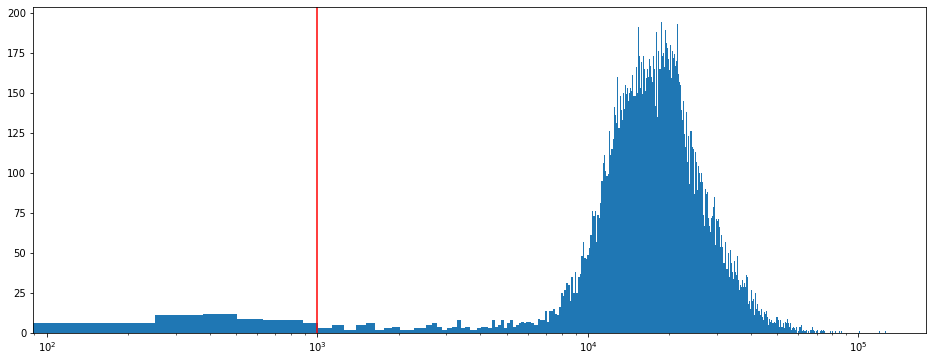

In [233]:
temp = df.groupby( [ 'Location', pd.Grouper(key="DateTime", freq='D')] ).sum().reset_index()
#temp.loc[temp.Count < 1000]
#temp["Count"].hist(bins=1000)
CUTOFF = 1000
plt.figure(figsize=(16,6))
plt.xscale('log')
plt.hist(temp["Count"],bins=1000)
plt.axvline(x=CUTOFF, color="red")
plt.show()

#temp = df.groupby( [ 'Location', pd.Grouper(key="DateTime", freq='D')] ).sum().reset_index()
#temp.loc[temp.Count < 1000]

Even with a very low cutoff, most of those days actually look like they're correct (e.g. many are xmas day).So I wont remove any

In [202]:
temp2 = temp.loc[temp.Count<CUTOFF]
print(f"These {len(temp2)} days have counts below the cutoff:")
temp2

These 67 days have counts below the cutoff:


,Location,DateTime,Hour,Count
131,Albion Street North,2008-12-25,276,366
496,Albion Street North,2009-12-25,276,193
861,Albion Street North,2010-12-25,276,207
1226,Albion Street North,2011-12-25,276,329
1592,Albion Street North,2012-12-25,276,317
...,...,...,...,...
24467,Headrow,2011-12-25,276,568
24833,Headrow,2012-12-25,276,669
25198,Headrow,2013-12-25,276,707
25563,Headrow,2014-12-25,276,661


In [203]:
# Can also print the individual hours for each of these days, but again they look OK
for loc, date, hour, count in temp2.values:
    print(loc,date,hour,count)
    print(df.loc[ (df.Location==loc) & (df.DateTime>=date.replace(hour=0)) & (df.DateTime<=date.replace(hour=23)), ["Location", "DateTime", "Count"]])
    break # Don't do them all because it takes up loads of space

Albion Street North 2008-12-25 00:00:00 276 366
                 Location            DateTime  Count
3144  Albion Street North 2008-12-25 00:00:00      0
3145  Albion Street North 2008-12-25 01:00:00      0
3146  Albion Street North 2008-12-25 02:00:00      0
3147  Albion Street North 2008-12-25 03:00:00      0
3148  Albion Street North 2008-12-25 04:00:00      0
3149  Albion Street North 2008-12-25 05:00:00      0
3150  Albion Street North 2008-12-25 06:00:00      0
3151  Albion Street North 2008-12-25 07:00:00      3
3152  Albion Street North 2008-12-25 08:00:00     10
3153  Albion Street North 2008-12-25 09:00:00     11
3154  Albion Street North 2008-12-25 10:00:00     17
3155  Albion Street North 2008-12-25 11:00:00     38
3156  Albion Street North 2008-12-25 12:00:00     46
3157  Albion Street North 2008-12-25 13:00:00     52
3158  Albion Street North 2008-12-25 14:00:00     37
3159  Albion Street North 2008-12-25 15:00:00     33
3160  Albion Street North 2008-12-25 16:00:00     3

In [234]:
# cleanup
del temp, temp2

Optionally save to a csv file

In [237]:
# Optionally save as a csv file for reading elsewhere
#df.to_csv("data/lcc_footfall_combined.csv")

### Manual checking

Choose a few dates, times, locations and check the data in the dataframe match those in the raw file. I've been doing this by openning a few of the csv files in excel, creating a pivot table to show counts per day and hour, and then comparing those numbers to the ones in the aggregate file.

Use file [`monthly-data-feed-aug-2014-20140904.csv`](./data/lcc_footfall/monthly-data-feed-aug-2014-20140904.csv).

In [238]:
# Check time for one hour
assert dfg.loc[dfg.index==pd.to_datetime("2014-08-20 10:00:00"), "Count" ].values[0] == 8370

# Check time for a day
assert sum(dfg.loc[ (dfg.index>=pd.to_datetime("2014-08-20 00:00:00")) & \
                (dfg.index<pd.to_datetime("2014-08-21 00:00:00")) , "Count"]) == 175942

# Check time for a single row
assert  df.loc[ (df.DateTime==pd.to_datetime("2014-08-23 15:00:00") ) & \
                (df.Location=="Headrow"), "Count" ].values[0] == 1838

Use file [`Monthly%20Data%20Feed-October%202015%20-%2020151203.csv`](./data/lcc_footfall/Monthly%20Data%20Feed-October%202015%20-%2020151203.csv)

In [239]:
# Check time for one hour
assert dfg.loc[dfg.index==pd.to_datetime("2015-10-20 10:00:00"), "Count" ].values[0] == 7811

# Check time for a day
assert sum(dfg.loc[ (dfg.index>=pd.to_datetime("2015-10-20 00:00:00")) & \
                (dfg.index<pd.to_datetime("2015-10-21 00:00:00")) , "Count"]) == 167152

# Check time for a single row
assert  df.loc[ (df.DateTime==pd.to_datetime("2015-10-20 23:00:00") ) & \
                (df.Location=="Albion Street North"), "Count" ].values[0] == 48



### Plot Footfall

#### All footfall (every hourly count)

All cameras

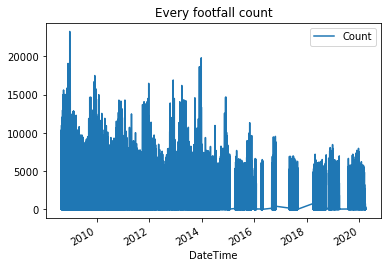

In [240]:
df.plot(x="DateTime", y="Count", title="Every footfall count")

Separate cameras

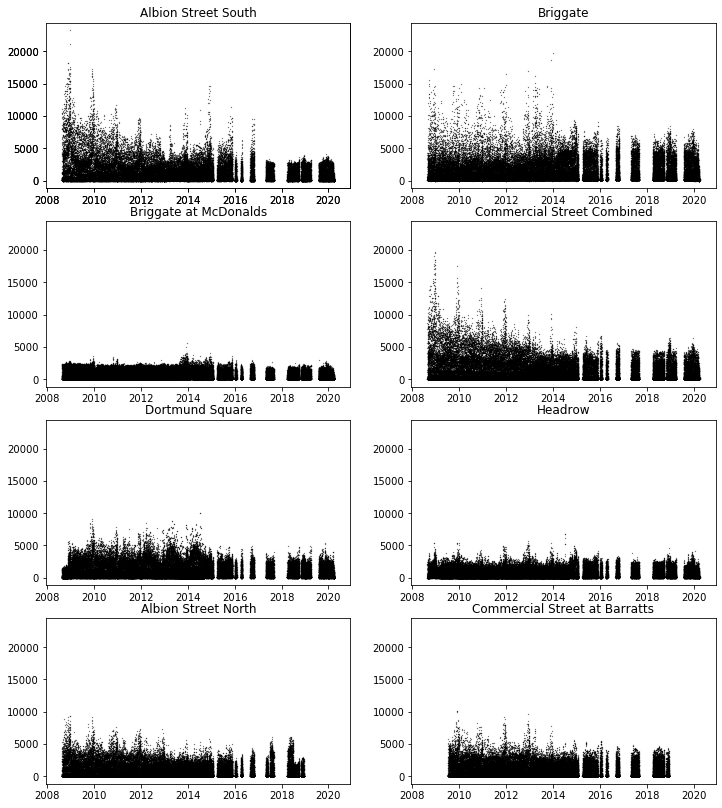

In [241]:
# plots for each location
fig = plt.figure(figsize=(12,14))
fig.tight_layout()
# Create a template axis fromBriggate (this has the most footfall). This will be overridden
shared_ax = fig.add_subplot(4, 2, 1) # rows, cols, indexsharex=ax
data = df.loc[ df.Location == "Briggate" , :]
shared_ax.scatter(data.DateTime, data.Count)

for i, loc in enumerate(df["Location"].unique()):
    ax = fig.add_subplot(4, 2, i+1, sharex=shared_ax, sharey=shared_ax) # rows, cols, index
    data = df.loc[ df.Location ==loc , :]
    ax.scatter(data.DateTime, data.Count, s=0.05, c="black")
    ax.set_title(f"{loc}")
    #df.loc[ df.Location =="Briggate" , :].plot(x="DateTime", y="Count", title=f"All footfall in {loc}")

#### Footfall by day, week, month

By Day.

_Note: need to use a `Grouper` to group on DateTime and Location_. Details [here](https://stackoverflow.com/questions/32012012/pandas-resample-timeseries-with-groupby)

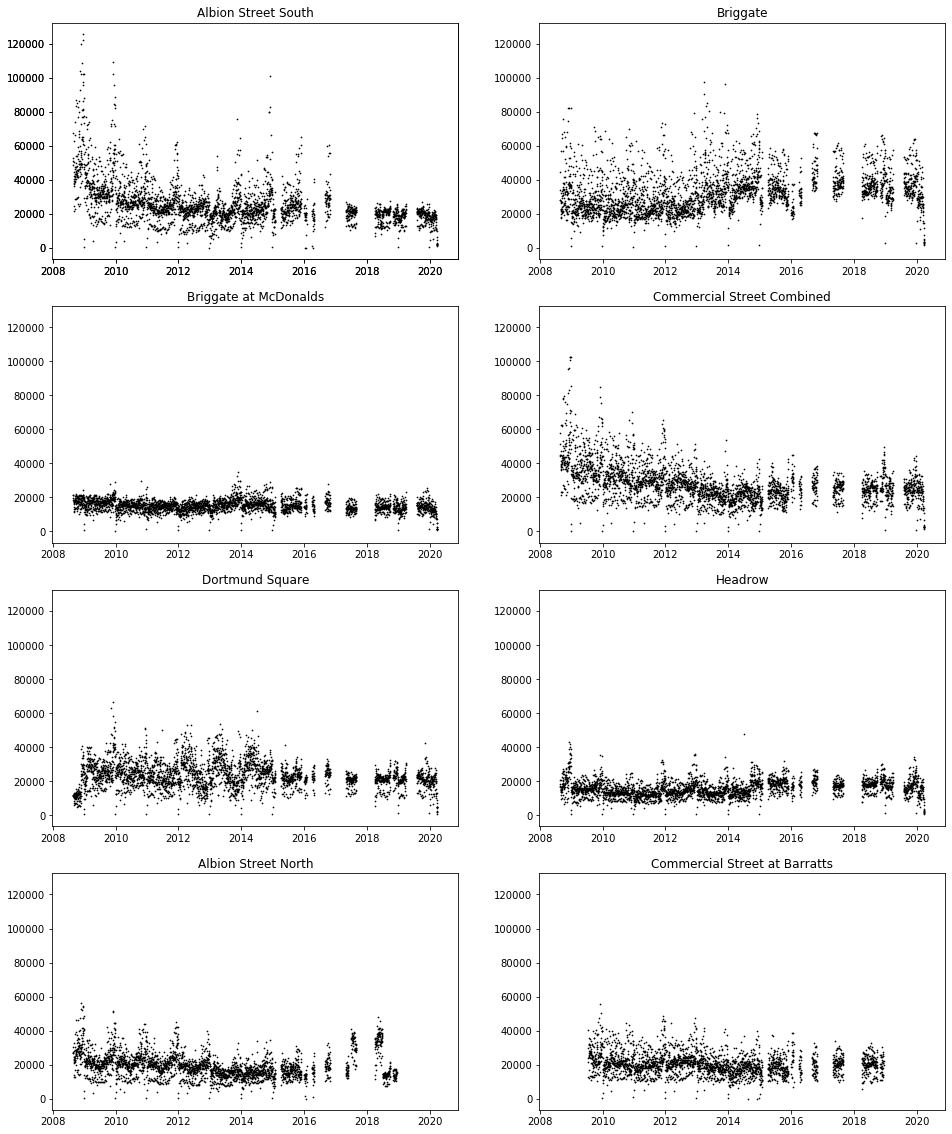

In [248]:
fig = plt.figure(figsize=(16,20))
fig.tight_layout()

# Group by location *And& 
data = df.groupby( [ 'Location', pd.Grouper(key="DateTime", freq='D')] ).sum().reset_index()

# Create a template axis fromBriggate (this has the most footfall). This will be overridden
shared_ax = fig.add_subplot(4, 2, 1) # rows, cols, indexsharex=ax
shared_ax.scatter(data.loc[data.Location=="Briggate","DateTime"], data.loc[data.Location=="Briggate","Count"])
for i, loc in enumerate(df["Location"].unique()):
    ax = fig.add_subplot(4, 2, i+1, sharex=shared_ax, sharey=shared_ax) # rows, cols, index
    d = data.loc[ data.Location ==loc , :]
    ax.scatter(d.DateTime, d.Count, s=0.5, c="black")
    ax.set_title(f"{loc}")

Text(0.5, 1.0, 'Footfall by day - all cameras')

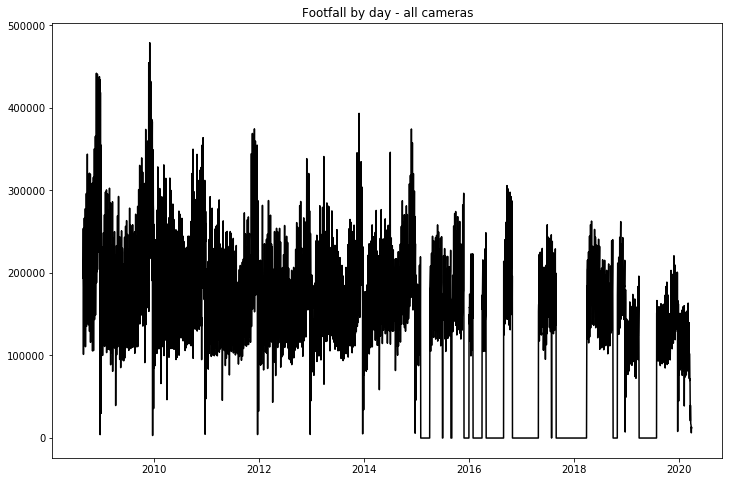

In [252]:
fig = plt.figure(figsize=(12,8))
fig.tight_layout()

ax = fig.add_subplot(1, 1, 1) # rows, cols, indexsharex=ax
data = df.groupby( [ pd.Grouper(key="DateTime", freq='D')] ).sum().reset_index()
#data = df.resample('D', on="DateTime").sum().reset_index()

ax.plot(data.DateTime, data.Count,c="black")
ax.set_title(f"Footfall by day - all cameras")


By Week

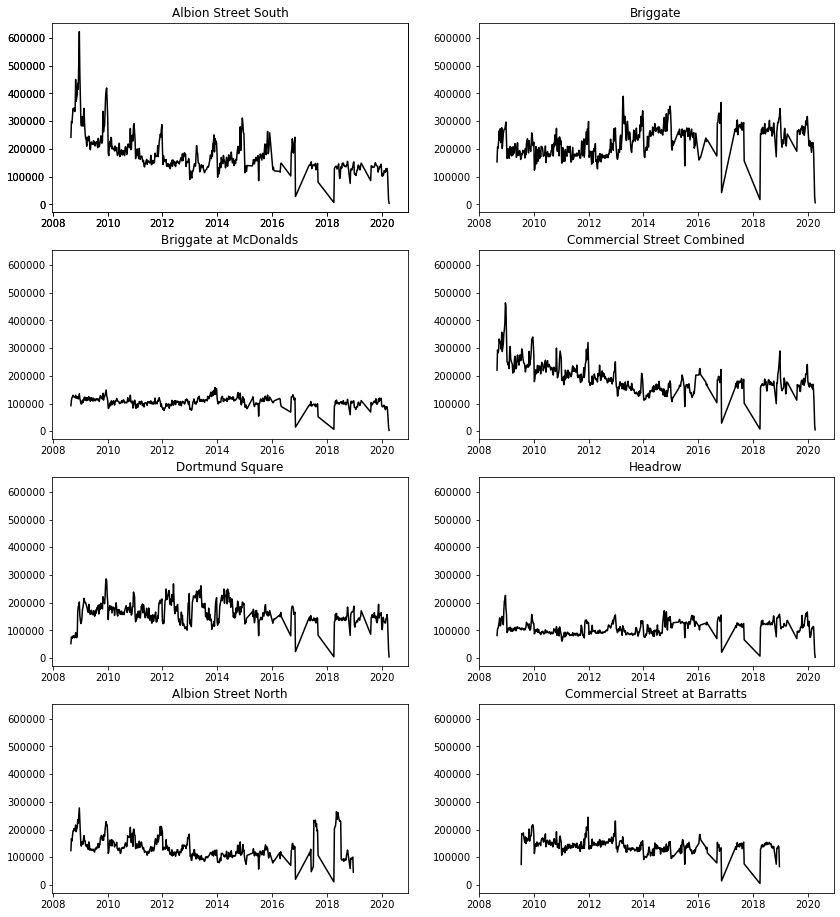

In [246]:
fig = plt.figure(figsize=(14,16))
fig.tight_layout()

# Group by location *And& 
data = df.groupby( [ 'Location', pd.Grouper(key="DateTime", freq='W')] ).sum().reset_index()

# Create a template axis fromBriggate (this has the most footfall). This will be overridden
shared_ax = fig.add_subplot(4, 2, 1) # rows, cols, indexsharex=ax
shared_ax.scatter(data.loc[data.Location=="Briggate","DateTime"], data.loc[data.Location=="Briggate","Count"])
for i, loc in enumerate(df["Location"].unique()):
    ax = fig.add_subplot(4, 2, i+1, sharex=shared_ax, sharey=shared_ax) # rows, cols, index
    d = data.loc[ data.Location ==loc , :]
    #ax.scatter(d.DateTime, d.Count, s=1.0, c="black")
    ax.plot(d.DateTime, d.Count, c="black")
    ax.set_title(f"{loc}")

Text(0.5, 1.0, 'Footfall by day - all cameras')

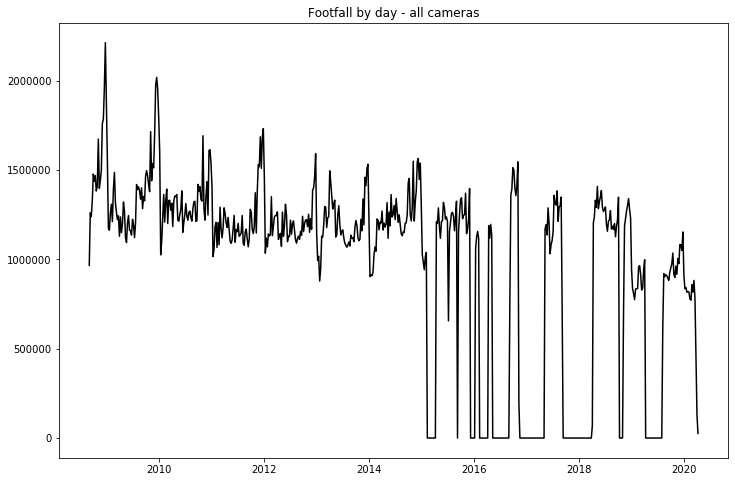

In [249]:
fig = plt.figure(figsize=(12,8))
fig.tight_layout()

ax = fig.add_subplot(1, 1, 1) # rows, cols, indexsharex=ax
data = df.groupby( [ pd.Grouper(key="DateTime", freq='W')] ).sum().reset_index()
data
ax.plot(data.DateTime, data.Count,c="black")
ax.set_title(f"Footfall by week - all cameras")


By Month

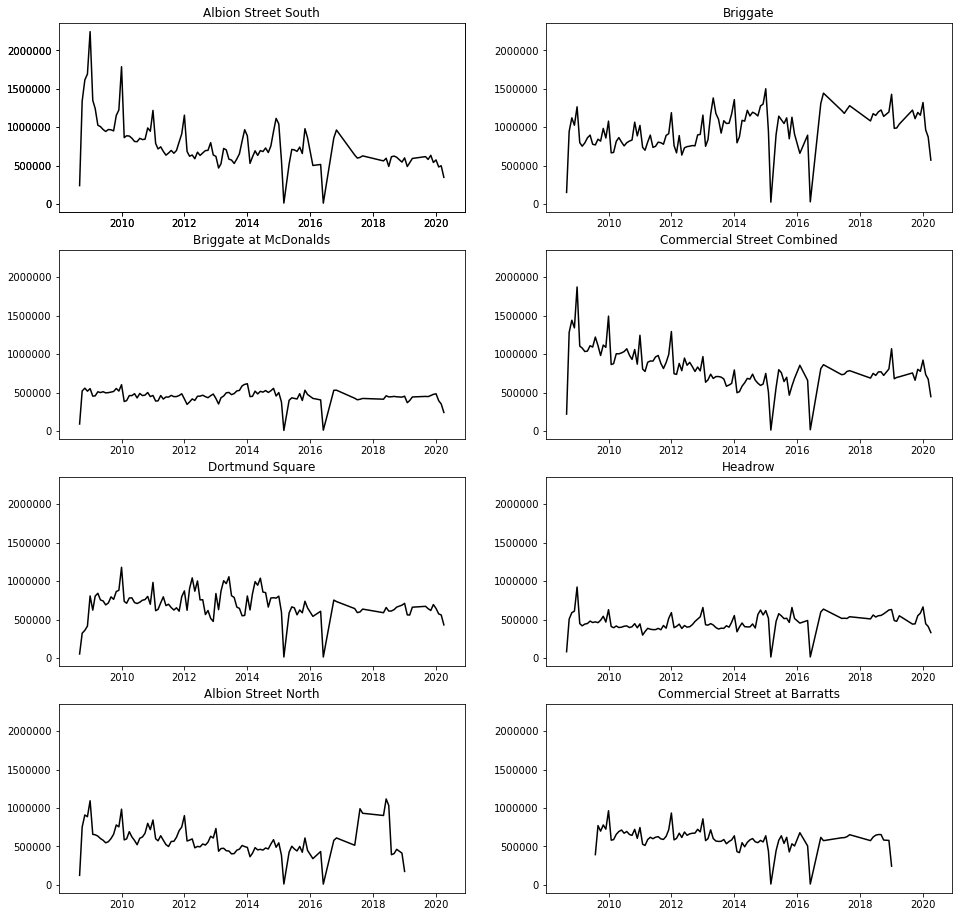

In [244]:
fig = plt.figure(figsize=(16,16))
fig.tight_layout()

# Group by location *And& 
data = df.groupby( [ 'Location', pd.Grouper(key="DateTime", freq='M')] ).sum().reset_index()

# Create a template axis fromBriggate (this has the most footfall). This will be overridden
shared_ax = fig.add_subplot(4, 2, 1) # rows, cols, indexsharex=ax
shared_ax.scatter(data.loc[data.Location=="Briggate","DateTime"], data.loc[data.Location=="Briggate","Count"])
for i, loc in enumerate(df["Location"].unique()):
    ax = fig.add_subplot(4, 2, i+1, sharex=shared_ax, sharey=shared_ax) # rows, cols, index
    d = data.loc[ data.Location ==loc , :].sort_values(by="DateTime")
    ax.plot(d.DateTime, d.Count, c="black")
    ax.set_title(f"{loc}")

In [245]:
# (Sanity check that we're not loosing counts)
assert sum(dfg.resample('W').sum()) == sum(df["Count"])

dfg.resample('W').sum().plot()

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [ ]:
#df_grouped = df.groupby(by=["Location", "DateTime"])
df2 = df.set_index("DateTime")
df2.groupby(by=[df2.index.month, df2.index.year]).agg("Count")

## Newcastle Urban Observatory

## Twitter
